In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
from simplexai.explainers.simplex import Simplex
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [4]:
# Load MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5,), (0.5,))]
)

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=4, shuffle=False)

In [5]:
# Create smaller subsets for corpus and test inputs
corpus_indices = np.random.choice(len(train_dataset), size=100, replace=False)
test_indices = np.random.choice(len(test_dataset), size=10, replace=False)

corpus_dataset = Subset(train_dataset, corpus_indices)
test_dataset = Subset(test_dataset, test_indices)

corpus_loader = torch.utils.data.DataLoader(corpus_dataset, batch_size=100, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)

corpus_inputs, _ = next(iter(corpus_loader))
test_inputs, _ = next(iter(test_loader))

In [36]:
from latent_model_classes import MNISTModel1, MNISTModel2, MNISTModel3
model = MNISTModel3()
model.load_state_dict(torch.load('models/model3_latent.pth', weights_only=True))
model.eval()

# Compute latent representations
corpus_inputs = corpus_inputs.to(device)
test_inputs = test_inputs.to(device)

corpus_latents = model.latent_representation(corpus_inputs).detach()
test_latents = model.latent_representation(test_inputs).detach()

In [37]:
simplex = Simplex(corpus_examples=corpus_inputs, corpus_latent_reps=corpus_latents)

# Fit SimplEx
simplex.fit(test_examples=test_inputs, test_latent_reps=test_latents, reg_factor=0)

Weight Fitting Epoch: 2000/10000 ; Error: 19 ; Regulator: 5.95 ; Reg Factor: 0
Weight Fitting Epoch: 4000/10000 ; Error: 11.9 ; Regulator: 2.39 ; Reg Factor: 0
Weight Fitting Epoch: 6000/10000 ; Error: 10.6 ; Regulator: 1.17 ; Reg Factor: 0
Weight Fitting Epoch: 8000/10000 ; Error: 10.3 ; Regulator: 0.772 ; Reg Factor: 0
Weight Fitting Epoch: 10000/10000 ; Error: 10.2 ; Regulator: 0.597 ; Reg Factor: 0


In [ ]:
# weights = simplex.weights

# # Compute the Integrated Jacobian for a specific example
# input_baseline = torch.zeros_like(corpus_inputs)
# i = 1  # Index of the test example to explain
# simplex.jacobian_projection(test_id=i, model=model, input_baseline=input_baseline)

# # Decompose the test example
# result = simplex.decompose(i)

In [ ]:
# import matplotlib.pyplot as plt

# def show_image(image, title=None):
#     """Display an image with an optional title."""
#     plt.imshow(image.squeeze().cpu(), cmap='gray')
#     if title:
#         plt.title(title)
#     plt.axis('off')
#     plt.show()

# # Visualize the test image and top k corpus examples
# test_image = test_inputs[i]
# show_image(test_image, title=f"Test Image (Index: {i})")

# # Top k corpus examples
# top_k_indices = weights[i].topk(k=3).indices
# for rank, idx in enumerate(top_k_indices, start=1):
#     show_image(corpus_inputs[idx], title=f"Top {rank} Corpus Example (Index: {idx.item()})")

In [28]:
from PIL import Image

def preprocess_image(image_path):
    """Load and preprocess an image to match MNIST format."""
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    image = Image.open(image_path)
    return transform(image).unsqueeze(0).to(device)

new_image = preprocess_image("../human_test_images/image.png")

In [ ]:
new_latent = model.latent_representation(new_image).detach()
new_latent = new_latent.expand(corpus_latents.shape[0], -1) # Expands to [100, latent_dim]

# Fit Simplex for the new image
simplex.fit(test_examples=new_image, test_latent_reps=new_latent, reg_factor=0)
result = simplex.decompose(test_id=0)

Weight Fitting Epoch: 2000/10000 ; Error: 795 ; Regulator: 52.1 ; Reg Factor: 0
Weight Fitting Epoch: 4000/10000 ; Error: 552 ; Regulator: 20.4 ; Reg Factor: 0
Weight Fitting Epoch: 6000/10000 ; Error: 516 ; Regulator: 13.3 ; Reg Factor: 0
Weight Fitting Epoch: 8000/10000 ; Error: 506 ; Regulator: 12.3 ; Reg Factor: 0
Weight Fitting Epoch: 10000/10000 ; Error: 502 ; Regulator: 11.8 ; Reg Factor: 0


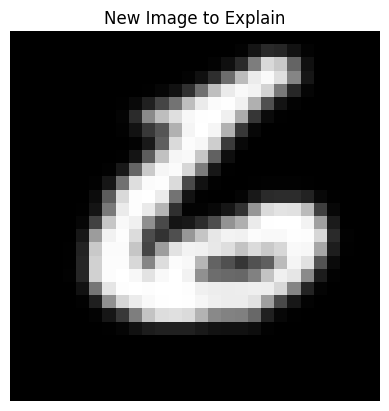

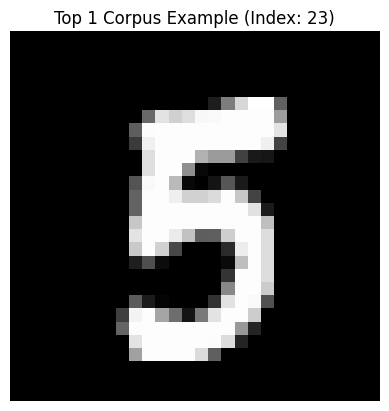

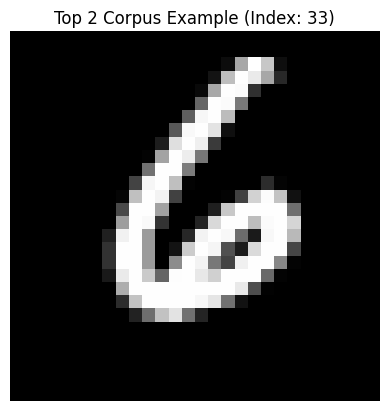

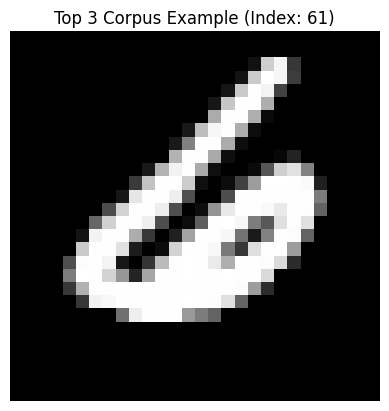

In [35]:
# Show the original image
show_image(new_image, title="New Image to Explain")

# Get top corpus examples
top_k_indices = simplex.weights[0].topk(k=3).indices
for rank, idx in enumerate(top_k_indices, start=1):
    show_image(corpus_inputs[idx], title=f"Top {rank} Corpus Example (Index: {idx.item()})")